In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report
import warnings
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
warnings.filterwarnings("ignore")

In [4]:
# Load the data from the file
file_path = "training_data.pkl"
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Access the X_train and y_train datasets from the loaded data dictionary
X = loaded_data["X_train"]
y = loaded_data["y_train"]
X_smote = loaded_data['X_train_smote']
y_smote = loaded_data['y_train_smote']
X_nearmiss = loaded_data['X_train_nearmiss']
y_nearmiss = loaded_data['y_train_nearmiss']

#### Building the Stacked Autoencoder Model and Fine Tuning

In [6]:
# Define stacked autoencoder architecture
def build_autoencoder(input_dim, hidden_dim):
    input_layer = Input(shape=(input_dim,))
    encoder1 = Dense(hidden_dim, activation='relu')(input_layer)
    output_layer = Dense(input_dim, activation='sigmoid')(encoder1)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Define supervised fine-tuning model architecture
def build_fine_tuning_model(inputs, outputs, output_dim):
    input_layer = inputs
    encoded_features = outputs
    output_layer = Dense(output_dim, activation='softmax')(encoded_features)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

#### Training and Evaluating on Skewed Dataset

In [5]:
# The Dictionary to Store all different view of the data
skew_output_dict = {}

# First Using the Original Dataset
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1011)
scaler = StandardScaler()
X_remaining = scaler.fit_transform(X_remaining)
X_test = scaler.transform(X_test)

#### Fully Supervised i.e. 100% using Labeled Data

In [7]:
# Build stacked autoencoder
input_dim = X_remaining.shape[1]
hidden_dim = 64
autoencoder = build_autoencoder(input_dim, hidden_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# Train stacked autoencoder
autoencoder.fit(X_remaining, X_remaining, epochs=10, batch_size=32)

Epoch 1/10
1131/1131 [==============================] - 4s 3ms/step - loss: 0.6747
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5820
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5782
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5769
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5763
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5759
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5757
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5756
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5755
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.5754


In [10]:
# Extract encoder part from autoencoder
encoder_inputs=autoencoder.input
encoder_outputs = autoencoder.layers[1].output

# Build supervised fine-tuning model
output_dim = 2
fine_tuning_model = build_fine_tuning_model(encoder_inputs,encoder_outputs, output_dim)
fine_tuning_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune model with labeled data
fine_tuning_model.fit(X_remaining, y_remaining, epochs=10, batch_size=32)

Epoch 1/10
1131/1131 [==============================] - 4s 3ms/step - loss: 0.2787 - accuracy: 0.8915
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2405 - accuracy: 0.8990
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2339 - accuracy: 0.9016
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2307 - accuracy: 0.9016
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2295 - accuracy: 0.9024
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2275 - accuracy: 0.9025
Epoch 7/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2268 - accuracy: 0.9040
Epoch 8/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2264 - accuracy: 0.9042
Epoch 9/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.2254 - accuracy: 0.9040
Epoch 10/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.224

In [11]:
# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = fine_tuning_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

283/283 [==============================] - 1s 3ms/step - loss: 0.2333 - accuracy: 0.8999
Test Loss: 0.23331107199192047
Test Accuracy: 0.8999226093292236


In [14]:
#Generating Predictions
y_preds = fine_tuning_model.predict(X_test)

y_preds = np.argmax(y_preds, axis=1)

accuracy = accuracy_score(y_test, y_preds)
confusion_matrix_test = confusion_matrix(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}

skew_output_dict['1'] = result

283/283 [==============================] - 1s 2ms/step


#### Training the model with 50%, 75%, 90%, 95% and 99% unlabeled data¶

In [16]:
labeled_data_perc = [0.5,0.25,0.1,0.05,0.01]

for i,perc in enumerate(labeled_data_perc):
    # Further split the remaining data into Labelled data and Unlabeled data
    print(f"Iteration: {i+1}, labeled Data Percentage: {perc*100}%")
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_remaining,
                                                                      y_remaining, 
                                                                      train_size=perc, 
                                                                      stratify=y_remaining, 
                                                                      random_state=1011)
    # Build stacked autoencoder
    input_dim = X_unlabeled.shape[1]
    hidden_dim = 64
    autoencoder = build_autoencoder(input_dim, hidden_dim)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Train stacked autoencoder
    autoencoder.fit(X_unlabeled, X_unlabeled, epochs=10, batch_size=32)

    # Extract encoder part from autoencoder
    encoder_inputs=autoencoder.input
    encoder_outputs = autoencoder.layers[1].output
    
    # Build supervised fine-tuning model
    output_dim = 2
    fine_tuning_model = build_fine_tuning_model(encoder_inputs,encoder_outputs, output_dim)
    fine_tuning_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Fine-tune model with labeled data
    fine_tuning_model.fit(X_labeled, y_labeled, epochs=10, batch_size=32)

    print("Model Fitting Completed..")

    # Evaluate the fine-tuned model on the test set
    test_loss, test_accuracy = fine_tuning_model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    
    #Generating Predictions
    y_preds = fine_tuning_model.predict(X_test)
    
    y_preds = np.argmax(y_preds, axis=1)
    
    print("Model Predictions Completed..")
    #Calculating Metrics
    accuracy = accuracy_score(y_test, y_preds)
    confusion_matrix_test = confusion_matrix(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test,y_preds)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    
    result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}
    print("Results Dict Generated..")
    skew_output_dict[str(i+2)] = result
    print()

Iteration: 1, labeled Data Percentage: 50.0%
Epoch 1/10
566/566 [==============================] - 3s 3ms/step - loss: 0.7610
Epoch 2/10
566/566 [==============================] - 2s 3ms/step - loss: 0.6022
Epoch 3/10
566/566 [==============================] - 2s 3ms/step - loss: 0.5898
Epoch 4/10
566/566 [==============================] - 1s 2ms/step - loss: 0.5860
Epoch 5/10
566/566 [==============================] - 2s 3ms/step - loss: 0.5844
Epoch 6/10
566/566 [==============================] - 2s 3ms/step - loss: 0.5834
Epoch 7/10
566/566 [==============================] - 2s 3ms/step - loss: 0.5828
Epoch 8/10
566/566 [==============================] - 2s 3ms/step - loss: 0.5824
Epoch 9/10
566/566 [==============================] - 2s 3ms/step - loss: 0.5820
Epoch 10/10
566/566 [==============================] - 2s 3ms/step - loss: 0.5818
Epoch 1/10
566/566 [==============================] - 5s 4ms/step - loss: 0.4811 - accuracy: 0.8447
Epoch 2/10
566/566 [========================

#### Results on skewed Dataset

In [17]:
# Print all metrics for each model
labeled_data_perc = [1.0,0.5,0.25,0.1,0.05,0.01]
for model_num, metrics in skew_output_dict.items():
    print(f"Model {model_num} Metrics: {100 - (labeled_data_perc[int(model_num)-1])*100}% of Unlabeled Data")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1']}\n")

Model 1 Metrics: 0.0% of Unlabeled Data
Accuracy: 0.899922592060157
Precision: 0.628140703517588
Recall: 0.3544423440453686
F1 Score: 0.45317220543806647

Model 2 Metrics: 50.0% of Unlabeled Data
Accuracy: 0.8977109366360722
Precision: 0.5887850467289719
Recall: 0.4168241965973535
F1 Score: 0.4881018262313226

Model 3 Metrics: 75.0% of Unlabeled Data
Accuracy: 0.8968262744664381
Precision: 0.5912408759124088
Recall: 0.3827977315689981
F1 Score: 0.46471600688468157

Model 4 Metrics: 90.0% of Unlabeled Data
Accuracy: 0.8960521950680084
Precision: 0.5821727019498607
Recall: 0.3950850661625709
F1 Score: 0.4707207207207207

Model 5 Metrics: 95.0% of Unlabeled Data
Accuracy: 0.8949463673559659
Precision: 0.5818181818181818
Recall: 0.3629489603024575
F1 Score: 0.44703143189755534

Model 6 Metrics: 99.0% of Unlabeled Data
Accuracy: 0.8809023554130266
Precision: 0.4816955684007707
Recall: 0.23629489603024575
F1 Score: 0.31705770450221943



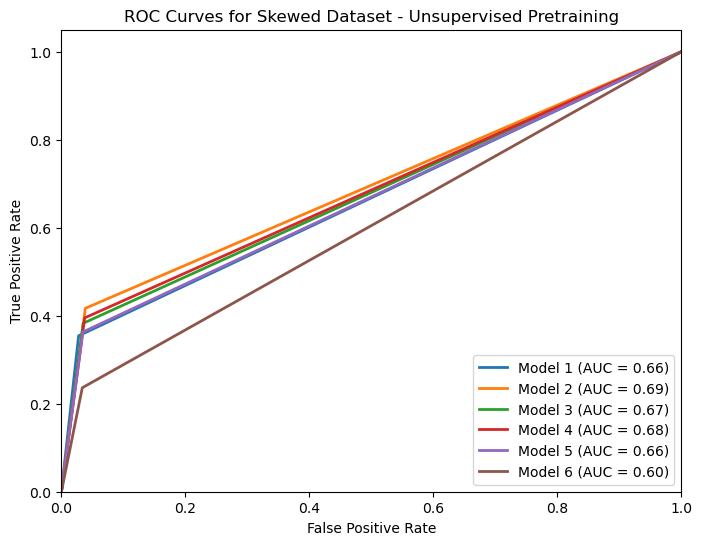

In [20]:
plt.figure(figsize=(8, 6))
for model_num, metrics in skew_output_dict.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['roc_auc']
    plt.plot(fpr, tpr, lw=2, label='Model {} (AUC = {:.2f})'.format(model_num, roc_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Skewed Dataset - Unsupervised Pretraining')
plt.legend(loc="lower right")
plt.savefig('ROC Curves for Skewed Dataset - Unsupervised Pretraining.png')
plt.show()

#### Training and Evaluation in Undersampled Dataset

In [21]:
# The Dictionary to Store all different view of the data
nearmiss_output_dict = {}

# First Using the Original Dataset
X_remaining, X_test, y_remaining, y_test = train_test_split(X_nearmiss, y_nearmiss, test_size=0.2, stratify=y_nearmiss, random_state=1011)
scaler = StandardScaler()
X_remaining = scaler.fit_transform(X_remaining)
X_test = scaler.transform(X_test)

#### Fully Supervised i.e. 100% using Labeled Data

In [22]:
# Build stacked autoencoder
input_dim = X_remaining.shape[1]
hidden_dim = 64
autoencoder = build_autoencoder(input_dim, hidden_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# Train stacked autoencoder
autoencoder.fit(X_remaining, X_remaining, epochs=10, batch_size=32)

# Extract encoder part from autoencoder
encoder_inputs=autoencoder.input
encoder_outputs = autoencoder.layers[1].output

# Build supervised fine-tuning model
output_dim = 2
fine_tuning_model = build_fine_tuning_model(encoder_inputs,encoder_outputs, output_dim)
fine_tuning_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune model with labeled data
fine_tuning_model.fit(X_remaining, y_remaining, epochs=10, batch_size=32)

# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = fine_tuning_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

#Generating Predictions
y_preds = fine_tuning_model.predict(X_test)

y_preds = np.argmax(y_preds, axis=1)

accuracy = accuracy_score(y_test, y_preds)
confusion_matrix_test = confusion_matrix(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}

nearmiss_output_dict['1'] = result

Epoch 1/10
265/265 [==============================] - 1s 1ms/step - loss: 0.8735
Epoch 2/10
265/265 [==============================] - 0s 1ms/step - loss: 0.6319
Epoch 3/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5886
Epoch 4/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5740
Epoch 5/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5674
Epoch 6/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5639
Epoch 7/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5618
Epoch 8/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5603
Epoch 9/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5592
Epoch 10/10
265/265 [==============================] - 0s 1ms/step - loss: 0.5585
Epoch 1/10
265/265 [==============================] - 1s 1ms/step - loss: 0.7838 - accuracy: 0.6093
Epoch 2/10
265/265 [==============================] - 0s 1ms/step - loss: 0.6156 - accura

#### Training the model with 50%, 75%, 90%, 95% and 99% unlabeled data¶

In [23]:
labeled_data_perc = [0.5,0.25,0.1,0.05,0.01]

for i,perc in enumerate(labeled_data_perc):
    # Further split the remaining data into Labelled data and Unlabeled data
    print(f"Iteration: {i+1}, labeled Data Percentage: {perc*100}%")
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_remaining,
                                                                      y_remaining, 
                                                                      train_size=perc, 
                                                                      stratify=y_remaining, 
                                                                      random_state=1011)
    # Build stacked autoencoder
    input_dim = X_unlabeled.shape[1]
    hidden_dim = 64
    autoencoder = build_autoencoder(input_dim, hidden_dim)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Train stacked autoencoder
    autoencoder.fit(X_unlabeled, X_unlabeled, epochs=10, batch_size=32)

    # Extract encoder part from autoencoder
    encoder_inputs=autoencoder.input
    encoder_outputs = autoencoder.layers[1].output
    
    # Build supervised fine-tuning model
    output_dim = 2
    fine_tuning_model = build_fine_tuning_model(encoder_inputs,encoder_outputs, output_dim)
    fine_tuning_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Fine-tune model with labeled data
    fine_tuning_model.fit(X_labeled, y_labeled, epochs=10, batch_size=32)

    print("Model Fitting Completed..")

    # Evaluate the fine-tuned model on the test set
    test_loss, test_accuracy = fine_tuning_model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    
    #Generating Predictions
    y_preds = fine_tuning_model.predict(X_test)
    
    y_preds = np.argmax(y_preds, axis=1)
    
    print("Model Predictions Completed..")
    #Calculating Metrics
    accuracy = accuracy_score(y_test, y_preds)
    confusion_matrix_test = confusion_matrix(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test,y_preds)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    
    result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}
    print("Results Dict Generated..")
    nearmiss_output_dict[str(i+2)] = result
    print()

Iteration: 1, labeled Data Percentage: 50.0%
Epoch 1/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9970
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7239
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.6302
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.5930
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.5746
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.5641
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.5577
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.5534
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.5505
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.5484
Epoch 1/10
133/133 [==============================] - 1s 1ms/step - loss: 0.9211 - accuracy: 0.6081
Epoch 2/10
133/133 [========================

#### Results on Under Sampled Dataset

In [24]:
# Print all metrics for each model
labeled_data_perc = [1.0,0.5,0.25,0.1,0.05,0.01]
for model_num, metrics in nearmiss_output_dict.items():
    print(f"Model {model_num} Metrics: {100 - (labeled_data_perc[int(model_num)-1])*100}% of Unlabeled Data")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1']}\n")

Model 1 Metrics: 0.0% of Unlabeled Data
Accuracy: 0.717391304347826
Precision: 0.7031802120141343
Recall: 0.7523629489603024
F1 Score: 0.7269406392694063

Model 2 Metrics: 50.0% of Unlabeled Data
Accuracy: 0.6947069943289225
Precision: 0.6886446886446886
Recall: 0.7107750472589792
F1 Score: 0.6995348837209303

Model 3 Metrics: 75.0% of Unlabeled Data
Accuracy: 0.6862003780718336
Precision: 0.6927592954990215
Recall: 0.6691871455576559
F1 Score: 0.6807692307692307

Model 4 Metrics: 90.0% of Unlabeled Data
Accuracy: 0.6677693761814745
Precision: 0.6632934682612696
Recall: 0.6814744801512287
F1 Score: 0.6722610722610722

Model 5 Metrics: 95.0% of Unlabeled Data
Accuracy: 0.6517013232514177
Precision: 0.6547733847637416
Recall: 0.6417769376181475
F1 Score: 0.6482100238663485

Model 6 Metrics: 99.0% of Unlabeled Data
Accuracy: 0.504725897920605
Precision: 0.5045045045045045
Recall: 0.5293005671077504
F1 Score: 0.5166051660516605



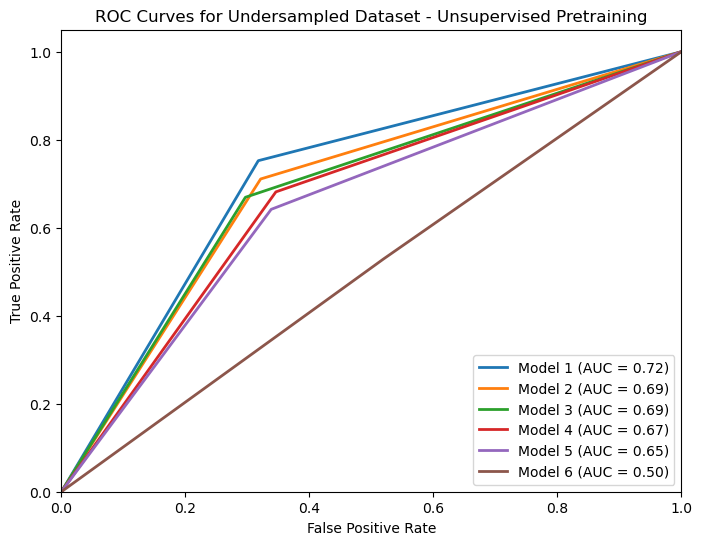

In [25]:
plt.figure(figsize=(8, 6))
for model_num, metrics in nearmiss_output_dict.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['roc_auc']
    plt.plot(fpr, tpr, lw=2, label='Model {} (AUC = {:.2f})'.format(model_num, roc_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Undersampled Dataset - Unsupervised Pretraining')
plt.legend(loc="lower right")
plt.savefig('ROC Curves for Undersampled Dataset - Unsupervised Pretraining.png')
plt.show()

#### Training and Evaluation in Oversampled Dataset

In [26]:
# The Dictionary to Store all different view of the data
smote_output_dict = {}

# First Using the Original Dataset
X_remaining, X_test, y_remaining, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=1011)
scaler = StandardScaler()
X_remaining = scaler.fit_transform(X_remaining)
X_test = scaler.transform(X_test)

#### Fully Supervised i.e. 100% using Labeled Data

In [27]:
# Build stacked autoencoder
input_dim = X_remaining.shape[1]
hidden_dim = 64
autoencoder = build_autoencoder(input_dim, hidden_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# Train stacked autoencoder
autoencoder.fit(X_remaining, X_remaining, epochs=10, batch_size=32)

# Extract encoder part from autoencoder
encoder_inputs=autoencoder.input
encoder_outputs = autoencoder.layers[1].output

# Build supervised fine-tuning model
output_dim = 2
fine_tuning_model = build_fine_tuning_model(encoder_inputs,encoder_outputs, output_dim)
fine_tuning_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune model with labeled data
fine_tuning_model.fit(X_remaining, y_remaining, epochs=10, batch_size=32)

# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = fine_tuning_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

#Generating Predictions
y_preds = fine_tuning_model.predict(X_test)

y_preds = np.argmax(y_preds, axis=1)

accuracy = accuracy_score(y_test, y_preds)
confusion_matrix_test = confusion_matrix(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}

smote_output_dict['1'] = result

Epoch 1/10
1997/1997 [==============================] - 3s 1ms/step - loss: 0.6549
Epoch 2/10
1997/1997 [==============================] - 3s 1ms/step - loss: 0.5980
Epoch 3/10
1997/1997 [==============================] - 2s 1ms/step - loss: 0.5961
Epoch 4/10
1997/1997 [==============================] - 2s 1ms/step - loss: 0.5955
Epoch 5/10
1997/1997 [==============================] - 3s 1ms/step - loss: 0.5953
Epoch 6/10
1997/1997 [==============================] - 3s 1ms/step - loss: 0.5951
Epoch 7/10
1997/1997 [==============================] - 2s 1ms/step - loss: 0.5950
Epoch 8/10
1997/1997 [==============================] - 2s 1ms/step - loss: 0.5949
Epoch 9/10
1997/1997 [==============================] - 2s 1ms/step - loss: 0.5949
Epoch 10/10
1997/1997 [==============================] - 2s 1ms/step - loss: 0.5949
Epoch 1/10
1997/1997 [==============================] - 3s 1ms/step - loss: 0.1889 - accuracy: 0.9273
Epoch 2/10
1997/1997 [==============================] - 2s 1ms/step

#### Training the model with 50%, 75%, 90%, 95% and 99% unlabeled data¶

In [28]:
labeled_data_perc = [0.5,0.25,0.1,0.05,0.01]

for i,perc in enumerate(labeled_data_perc):
    # Further split the remaining data into Labelled data and Unlabeled data
    print(f"Iteration: {i+1}, labeled Data Percentage: {perc*100}%")
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_remaining,
                                                                      y_remaining, 
                                                                      train_size=perc, 
                                                                      stratify=y_remaining, 
                                                                      random_state=1011)
    # Build stacked autoencoder
    input_dim = X_unlabeled.shape[1]
    hidden_dim = 64
    autoencoder = build_autoencoder(input_dim, hidden_dim)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Train stacked autoencoder
    autoencoder.fit(X_unlabeled, X_unlabeled, epochs=10, batch_size=32)

    # Extract encoder part from autoencoder
    encoder_inputs=autoencoder.input
    encoder_outputs = autoencoder.layers[1].output
    
    # Build supervised fine-tuning model
    output_dim = 2
    fine_tuning_model = build_fine_tuning_model(encoder_inputs,encoder_outputs, output_dim)
    fine_tuning_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Fine-tune model with labeled data
    fine_tuning_model.fit(X_labeled, y_labeled, epochs=10, batch_size=32)

    print("Model Fitting Completed..")

    # Evaluate the fine-tuned model on the test set
    test_loss, test_accuracy = fine_tuning_model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    
    #Generating Predictions
    y_preds = fine_tuning_model.predict(X_test)
    
    y_preds = np.argmax(y_preds, axis=1)
    
    print("Model Predictions Completed..")
    #Calculating Metrics
    accuracy = accuracy_score(y_test, y_preds)
    confusion_matrix_test = confusion_matrix(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test,y_preds)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    
    result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}
    print("Results Dict Generated..")
    smote_output_dict[str(i+2)] = result
    print()

Iteration: 1, labeled Data Percentage: 50.0%
Epoch 1/10
999/999 [==============================] - 2s 1ms/step - loss: 0.7112
Epoch 2/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6090
Epoch 3/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6040
Epoch 4/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6024
Epoch 5/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6017
Epoch 6/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6013
Epoch 7/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6011
Epoch 8/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6009
Epoch 9/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6008
Epoch 10/10
999/999 [==============================] - 1s 1ms/step - loss: 0.6007
Epoch 1/10
999/999 [==============================] - 2s 1ms/step - loss: 0.2501 - accuracy: 0.9056
Epoch 2/10
999/999 [========================

#### Results on Over Sampled Dataset

In [29]:
# Print all metrics for each model
labeled_data_perc = [1.0,0.5,0.25,0.1,0.05,0.01]
for model_num, metrics in smote_output_dict.items():
    print(f"Model {model_num} Metrics: {100 - (labeled_data_perc[int(model_num)-1])*100}% of Unlabeled Data")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1']}\n")

Model 1 Metrics: 0.0% of Unlabeled Data
Accuracy: 0.9373160498465778
Precision: 0.9627617280678505
Recall: 0.9098309329993738
F1 Score: 0.9355482583220656

Model 2 Metrics: 50.0% of Unlabeled Data
Accuracy: 0.9363141085853842
Precision: 0.9623142250530785
Recall: 0.9082028804007514
F1 Score: 0.9344758714000386

Model 3 Metrics: 75.0% of Unlabeled Data
Accuracy: 0.9363767299142087
Precision: 0.9551926845199217
Recall: 0.9157169693174703
F1 Score: 0.9350383631713555

Model 4 Metrics: 90.0% of Unlabeled Data
Accuracy: 0.9360010019412612
Precision: 0.955992141453831
Recall: 0.9140889167188478
F1 Score: 0.9345710627400767

Model 5 Metrics: 95.0% of Unlabeled Data
Accuracy: 0.9302398396893982
Precision: 0.9394908532685173
Recall: 0.919724483406387
F1 Score: 0.9295025946082774

Model 6 Metrics: 99.0% of Unlabeled Data
Accuracy: 0.9048782015154362
Precision: 0.9196521287642783
Recall: 0.8872886662492173
F1 Score: 0.9031805723755498



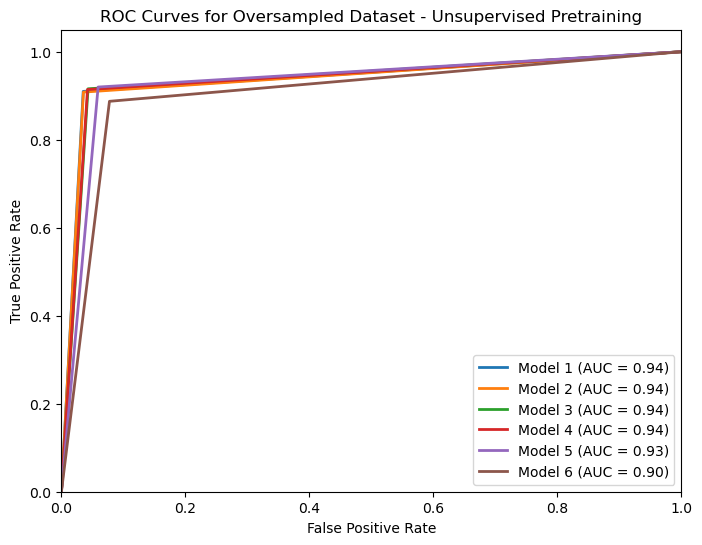

In [31]:
plt.figure(figsize=(8, 6))
for model_num, metrics in smote_output_dict.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['roc_auc']
    plt.plot(fpr, tpr, lw=2, label='Model {} (AUC = {:.2f})'.format(model_num, roc_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Oversampled Dataset - Unsupervised Pretraining')
plt.legend(loc="lower right")
plt.savefig('ROC Curves for Oversampled Dataset - Unsupervised Pretraining.png')
plt.show()